In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.seir import SEIR
from sir_models.seir import stepwise, get_quarantine_multiplier_value

# Load data

In [6]:
df = pd.read_csv('data/data.csv', sep=';')

In [7]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [8]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [9]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


In [10]:
print('First death')


First death


In [11]:
df = df[df.date >= df[df['total_dead'] > 0].iloc[0].date]
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
13,1129,2020-03-25,Москва,410,14,2,2,120,5,394
14,1214,2020-03-26,Москва,546,15,2,0,136,1,529
15,1299,2020-03-27,Москва,703,18,3,1,157,3,682
16,1384,2020-03-28,Москва,817,18,5,2,114,0,794
17,1469,2020-03-29,Москва,1014,28,6,1,197,10,980


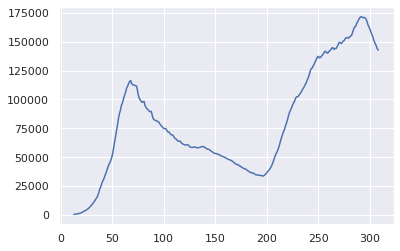

In [12]:
df['infected'].plot()

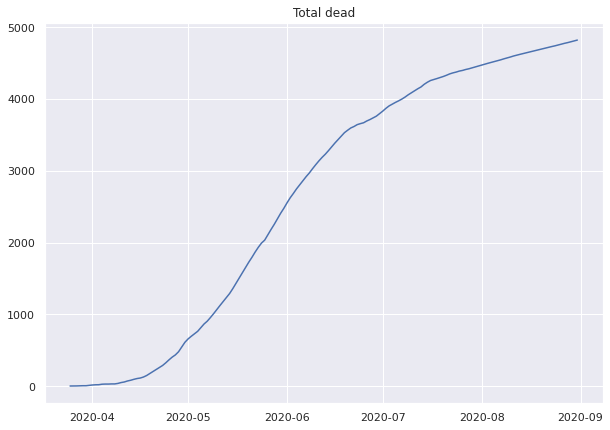

In [13]:
subset = df[(df.date >= '2020-03-01') & (df.date <= '2020-08-31')]
plt.figure(figsize=(10, 7))
plt.plot(subset.date, subset.total_dead)
plt.title("Total dead")
plt.show()

In [14]:
df[df['total_dead'] > 0].iloc[0]

index                               1129
date                 2020-03-25 00:00:00
region                            Москва
total_infected                       410
total_recovered                       14
total_dead                             2
deaths_per_day                         2
infected_per_day                     120
recovered_per_day                      5
infected                             394
Name: 13, dtype: object

# Smooth

In [15]:
df_smoothed = df.drop(columns=['region']).rolling(7).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-25
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-26
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-27
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-28
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-29
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-30
19,1384.0,904.142857,27.285714,5.000000,1.571429,189.000000,8.714286,871.857143,2020-03-31
20,1469.0,1114.142857,41.714286,7.000000,2.000000,210.000000,14.428571,1065.428571,2020-04-01
21,1554.0,1389.714286,59.571429,9.428571,2.428571,275.571429,17.857143,1320.714286,2020-04-02
22,1639.0,1706.857143,81.000000,11.857143,2.428571,317.142857,21.428571,1614.000000,2020-04-03


Text(0.5, 1.0, 'Active infected')

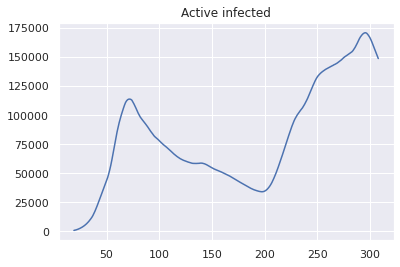

In [16]:
df_smoothed.infected.plot()
plt.title('Active infected')

Text(0.5, 1.0, 'Total infected')

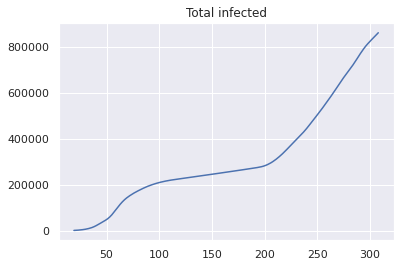

In [17]:
df_smoothed.total_infected.plot()
plt.title('Total infected')

Text(0.5, 1.0, 'Total dead')

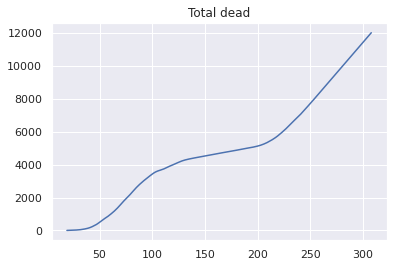

In [18]:
df_smoothed.total_dead.plot()
plt.title('Total dead')

In [19]:
# df = df_smoothed.dropna().reset_index(drop=True)

### Modelling infection fear and quarantine measures

[]

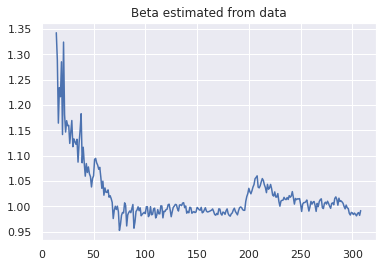

In [20]:
beta_from_data = df['infected'] / df['infected'].shift(1)
beta_from_data.plot()
plt.title('Beta estimated from data')
plt.plot()

In [21]:
beta_base = beta_from_data.max()
beta_base

1.3426395939086295

Text(0.5, 1.0, 'Infection "fear"')

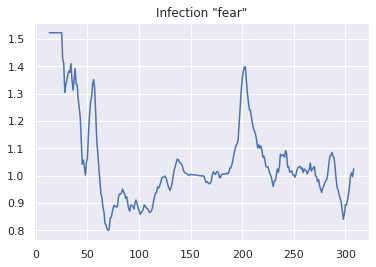

In [201]:
fear = df['infected_per_day']/df['infected_per_day'].rolling(7).mean()
fear = fear.rolling(7).mean().fillna(method='bfill')
plt.plot(fear)
plt.title('Infection "fear"')

In [213]:
fear.iloc[0]

1.5228429646243893

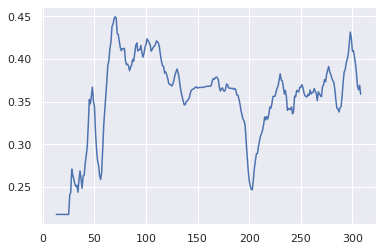

In [203]:
plt.plot(1/np.exp(fear))
plt.show()

In [192]:
beta_base

1.3426395939086295

In [199]:
1/np.exp(10)

4.539992976248485e-05

In [204]:
beta_base - 0.8 * 1/np.exp(2)

1.2343713673193393

[]

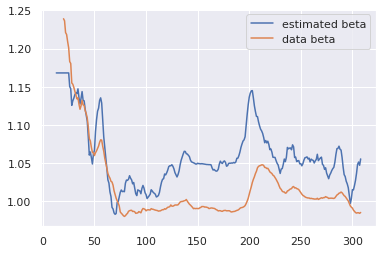

In [205]:
beta_fear = beta_base - 0.8 * 1/np.exp(fear)
plt.plot(beta_fear, label='estimated beta')
beta_from_data.rolling(7).mean().plot(label='data beta')
plt.legend()
plt.plot()

[]

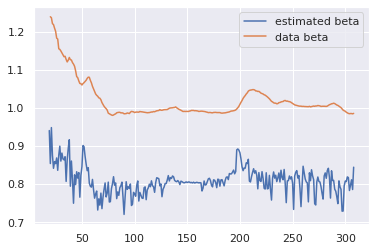

In [187]:
beta_fear = (3.55 - 2 * 1/np.exp(fear)) * 1/3.5
plt.plot(beta_fear, label='estimated beta')
beta_from_data.rolling(7).mean().plot(label='data beta')
plt.legend()
plt.plot()

In [24]:
beta_fear

13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
         ...   
304    1.019194
305    1.038356
306    1.058634
307    1.022832
308    1.104834
Name: infected_per_day, Length: 296, dtype: float64

In [25]:
beta_fear[50], beta_from_data[50]

(1.1068642003957876, 1.0600712603921405)

# SEIR full

In [223]:
model = SEIR()
subset = df
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
result

In [224]:
subset.iloc[0]

index                               1129
date                 2020-03-25 00:00:00
region                            Москва
total_infected                       410
total_recovered                       14
total_dead                             2
deaths_per_day                         2
infected_per_day                     120
recovered_per_day                      5
infected                             394
Name: 13, dtype: object

In [225]:
S[0], I[0], R[0], D[0]

(9831821.876587601, 173.6137122356812, 454.851947192877, 2.0843521001710252)

In [226]:
r0 = model.params['r0']
gamma = model.params['gamma']

rt_vals = []
for t in range(1, len(df)):
    rt_vals.append(r0 - get_quarantine_multiplier_value(t, model.params) * r0)
    
plt.figure()
plt.plot(rt_vals, label='Rt')
plt.legend()
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

In [227]:
r0, q_coefs

(<Parameter 'r0', value=3.55 (fixed), bounds=[-inf:inf]>,
 {30: 1.0,
  60: 1.0,
  90: 1.0,
  120: 1.0,
  150: 1.0,
  180: 1.0,
  210: 1.0,
  240: 1.0,
  270: 1.0})

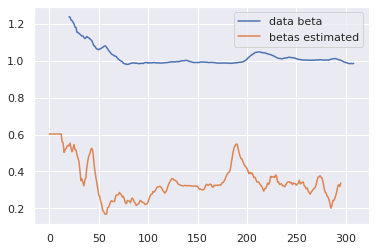

In [235]:
from sir_models.seir import beta_fear

betas = []
for t in range(len(subset)):
    betas.append(beta_fear(t, model.params['r0'] * model.params['gamma'], model.params['f'], model.fear))

beta_from_data.rolling(7).mean().plot(label='data beta')
plt.plot(betas, label='betas estimated')
plt.legend()
plt.show()

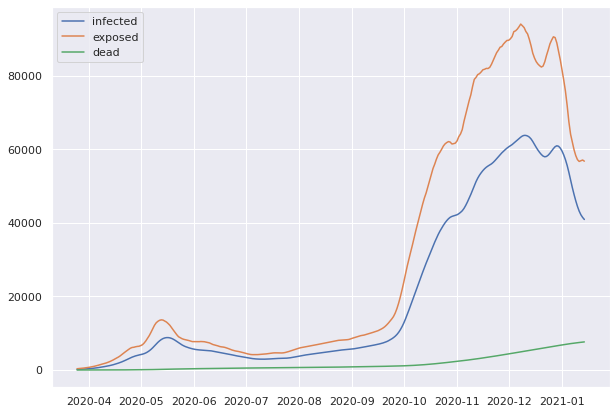

In [236]:
plt.figure(figsize=(10, 7))
plt.plot(subset.date, I, label='infected')
plt.plot(subset.date, E, label='exposed')
#plt.plot(subset.date, R, label='recovered')
plt.plot(subset.date, D, label='dead')
plt.legend()
plt.show()

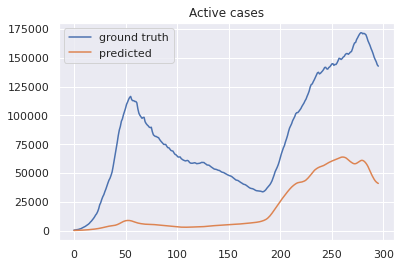

In [229]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

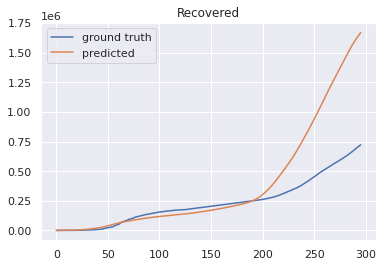

In [230]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

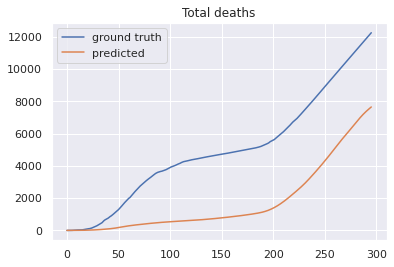

In [231]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

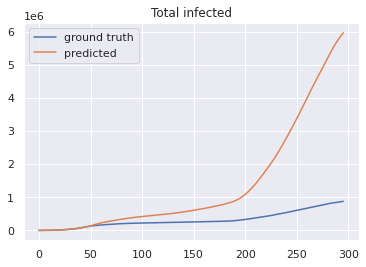

In [232]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()